#### Code for NWchem-Qiskit Driver
##### 1. import package

In [1]:
import numpy as np
import json
import sys
import yaml
import os
import matplotlib as plt
import pylab


from qiskit_nwchem_driver import nwchem_driver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.mappers.qubit_mapper import QubitMapper

from qiskit.exceptions import QiskitError
from qiskit_algorithms import VQE
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit.primitives import BaseEstimator
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver.vqe_avg import run_vqe_with_averaging


from qiskit.visualization import plot_histogram
from qiskit.visualization.timeline import draw, IQXSimple
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKyiv, FakeValenciaV2, FakeKyoto, FakeVigoV2
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi


from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates, noise_free_gates, numerical_gates, almost_noise_free_gates 
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import fix_counts

from qiskit import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit_aer import Aer, AerSimulator
from qiskit import transpile, assemble
from qiskit_aer import StatevectorSimulator
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator


from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.custom_ansatz import SDSfUCC, fUCC, tUPS



IBM_TOKEN='3199f66b51cb6ae29b8ea6b1033fc2918545d7426a4bd5e4e065123f19929d6d35e770b6e3f6b6e73f129baeee664be3a106d81f92b3a66be1f17ede8fbc83a6'


In [2]:
# data_dir = os.path.join("qe_files", "n2", "output")
# datafile = os.path.join(data_dir, "demo.out")
# data_file_yaml = os.path.join(data_dir, "demo.yaml")

data_dir = os.path.join("..","data","PW_LiH_data", "3x3_periodic", "NWChem",'1covo')
datafile = os.path.join(data_dir, "H1Li1-2.0.out")
data_file_yaml = os.path.join(data_dir, "H1Li1-2.0.yaml")

##### 2. nwchem output to yaml

In [3]:
data = extract_fields(datafile)
with open(data_file_yaml, 'w') as f:
    f.write(yaml.dump(data, default_flow_style=False)) 

##### 3. data to Qiskit electron structure problem class

In [4]:
driver = nwchem_driver.NWchem_Driver(data_file_yaml)
es_problem = driver.run()
hamiltonian  = es_problem.hamiltonian
print(hamiltonian)
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

h_ij up-down equal: True
eri up-down equal: True
eri up-(down-up) equal: False
eri (up-down)-(down-up) equal: True
Fermionic Operator
number spin orbitals=4, number terms=48
  -0.5246900086 * ( +_0 -_0 )
+ 0.1248196344 * ( +_0 -_1 )
+ 0.1248196344 * ( +_1 -_0 )
+ -0.1554481421 * ( +_1 -_1 )
+ -0.5246900086 * ( +_2 -_2 )
+ 0.1248196344 * ( +_2 -_3 )
+ 0.1248196344 * ( +_3 -_2 )
+ -0.1554481421 * ( +_3 -_3 )
+ 0.0620810131 * ( +_0 +_2 -_2 -_0 )
+ -0.03120481085 * ( +_0 +_2 -_3 -_0 )
+ -0.03120481085 * ( +_0 +_3 -_2 -_0 )
+ 0.028375930725 * ( +_0 +_3 -_3 -_0 )
+ 0.028375930725 * ( +_0 +_0 -_1 -_1 )
+ 0.053516168575 * ( +_0 +_1 -_0 -_1 )
+ -0.03120481085 * ( +_0 +_2 -_2 -_1 )
+ 0.028375930725 * ( +_0 +_2 -_3 -_1 )
+ 0.053516168575 * ( +_0 +_3 -_2 -_1 )
+ -0.030104954625 * ( +_0 +_3 -_3 -_1 )
+ 0.053516168575 * ( +_1 +_0 -_1 -_0 )
+ 0.028375930725 * ( +_1 +_1 -_0 -_0 )
+ -0.03120481085 * ( +_1 +_2 -_2 -_0 )
+ 0.053516168575 * ( +_1 +_2 -_3 -_0 )
+ 0.028375930725 * ( +_1 +_3 -_2 -_0 )
+ -0.0

##### 4. Mapping Hamiltonian to qubit

In [5]:
mapper = JordanWignerMapper()

In [6]:
hamiltonian_mapped =mapper.map(second_q_op)
print(hamiltonian_mapped)

SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IZIZ', 'YYIZ', 'XXIZ', 'ZIIZ', 'IIZZ', 'IZYY', 'IZXX', 'XYXY', 'YYYY', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'XXXX', 'YXYX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.6482921 +0.j,  0.24387462+0.j,  0.03175493+0.j,  0.03175493+0.j,
  0.06434841+0.j,  0.24387462+0.j,  0.03175493+0.j,  0.03175493+0.j,
  0.06434841+0.j,  0.03104051+0.j,  0.01560241+0.j,  0.01560241+0.j,
  0.01418797+0.j, -0.02675808+0.j,  0.01560241+0.j,  0.01560241+0.j,
  0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j, -0.00628506+0.j,
 -0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j,  0.00628506+0.j,
  0.01505248+0.j,  0.01505248+0.j,  0.01418797+0.j,  0.01505248+0.j,
  0.01505248+0.j,  0.02594578+0.j, -0.02675808+0.j])


##### 5. specify ansatz

In [7]:
ansatz_uccsd = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

##### 6. Add measurement

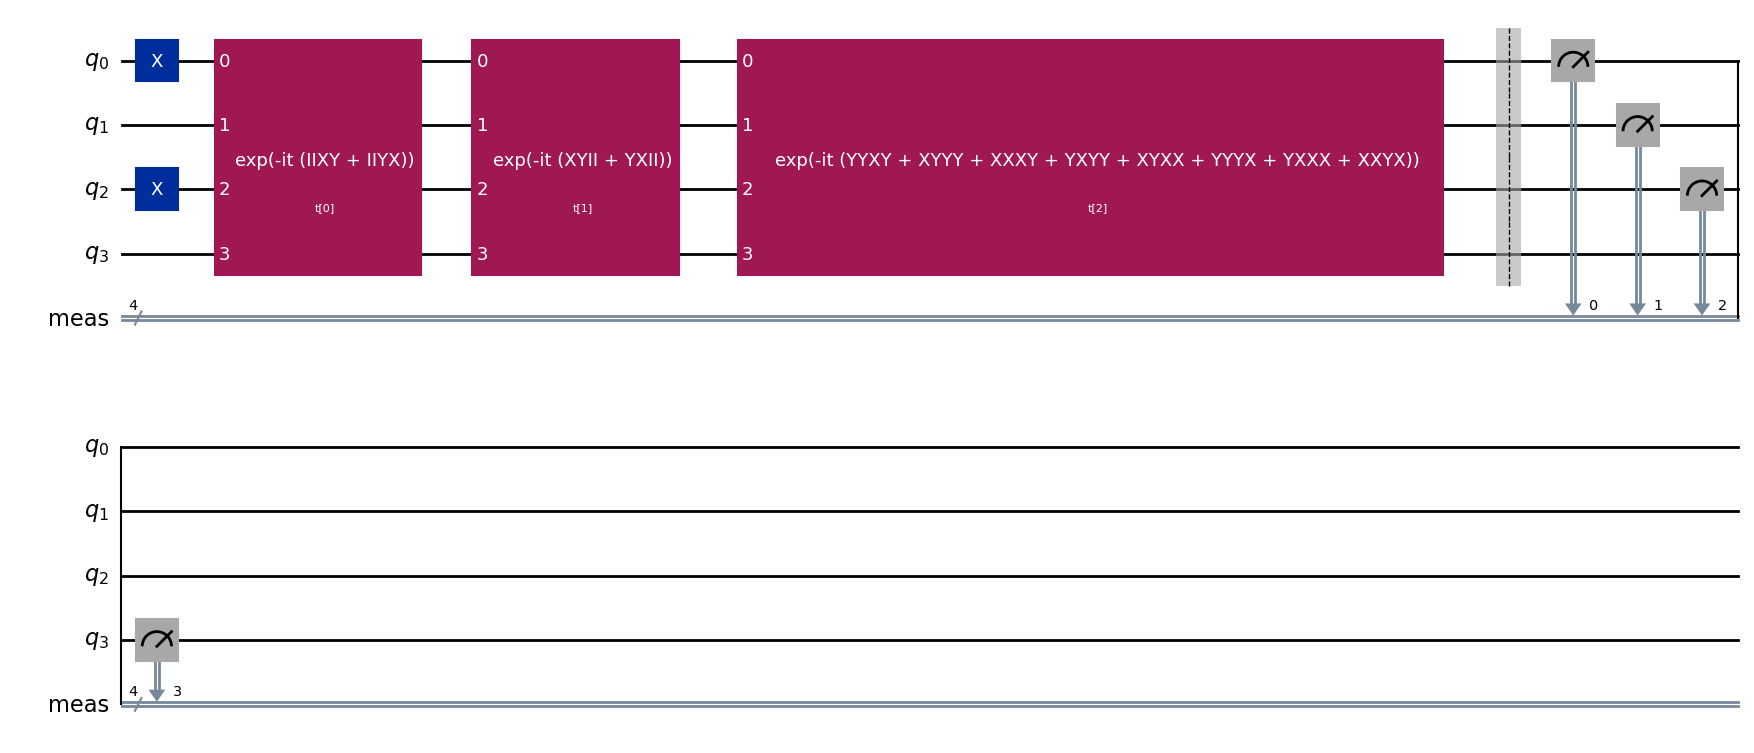

In [8]:
n_qubit = 4
n_classic_bit = 4
ansatz_circuit_uccsd = ansatz_uccsd.decompose()  
ansatz_circuit_uccsd.measure_all()
ansatz_circuit_uccsd.draw('mpl')  


##### 7. Define backend and transpile circuit

In [9]:
# directly with qiskit import a real device
provider = QiskitRuntimeService(channel= 'ibm_quantum', token=IBM_TOKEN)
provider.backends() 
backend_real = provider.backend('ibm_kyiv')

# fake backend without the use of the IBM_TOKEN to run the simulation
backend_fake = FakeKyiv()

linear_qubit_layout = [0,1,2,3] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake) # get parameters from the backend
device_param_lookup = device_param.__dict__() # get dict representation.
#print(device_param_lookup)

# transpilation of the circuit
t_circ_uccsd = transpile(
    ansatz_circuit_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=42,
    scheduling_method='asap'
)



##### 8. Define parameters

In [10]:
print(t_circ_uccsd.parameters)
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=t_circ_uccsd.num_parameters)
t_circ_uccsd = t_circ_uccsd.assign_parameters(params)



ParameterView([ParameterVectorElement(t[0]), ParameterVectorElement(t[1]), ParameterVectorElement(t[2])])


##### 9. Define and run simulator with correspondent gate set

In [11]:
sim_noise_ander = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_free_ander = MrAndersonSimulator(gates=noise_free_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_noise_aer = AerSimulator.from_backend(backend_fake)
sim_free_aer =AerSimulator()




In [52]:
probs_noise_ander_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 


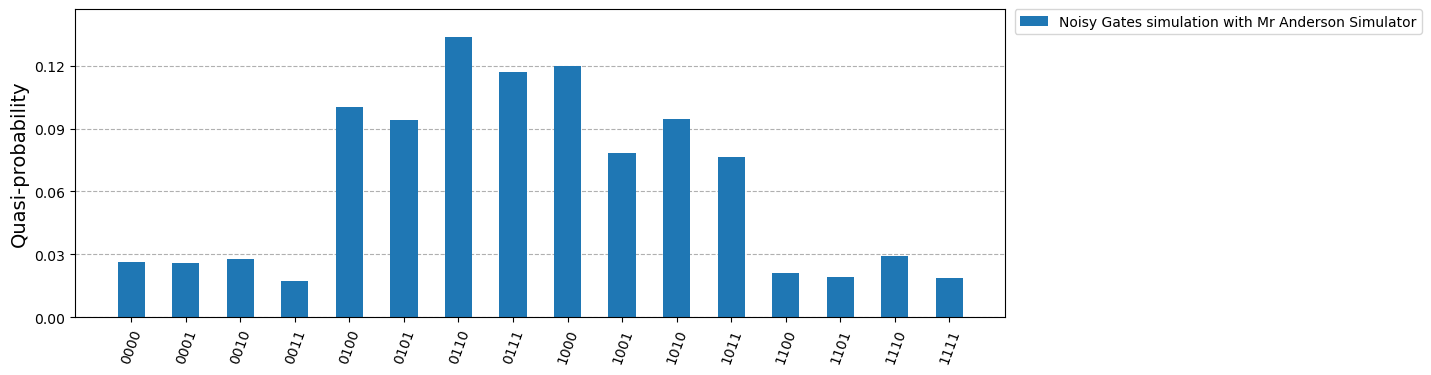

In [53]:
measured_qubit = n_classic_bit
counts_noise_ander_uccsd = fix_counts(probs_noise_ander_uccsd, n_classic_bit)
plot_histogram(counts_noise_ander_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [63]:
probs_free_ander_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

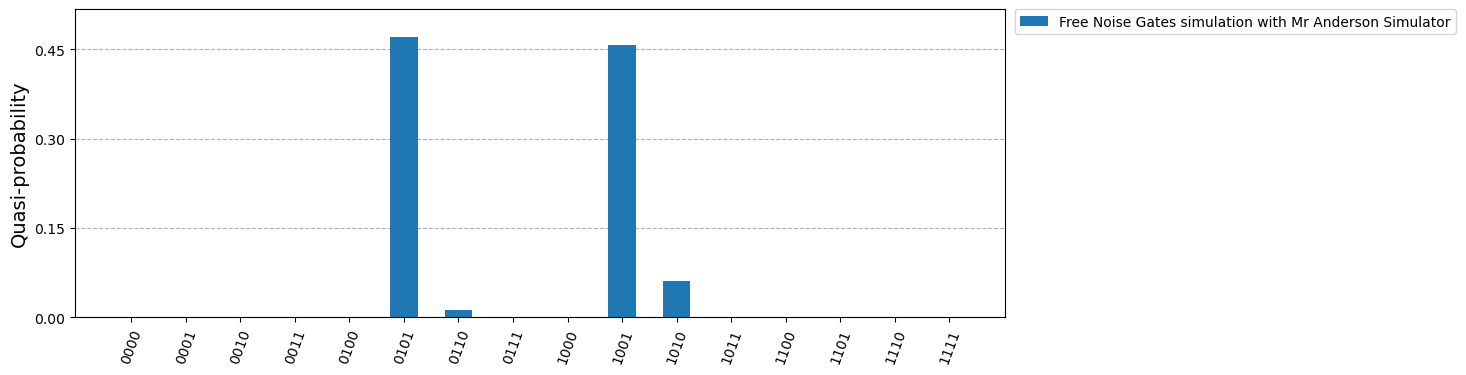

In [64]:
measured_qubit = n_classic_bit
counts_free_ander_uccsd = fix_counts(probs_free_ander_uccsd, n_classic_bit)
plot_histogram(counts_free_ander_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [65]:
probs_noise_aer_uccsd = sim_noise_aer.run(t_circ_uccsd, shots=10000).result()

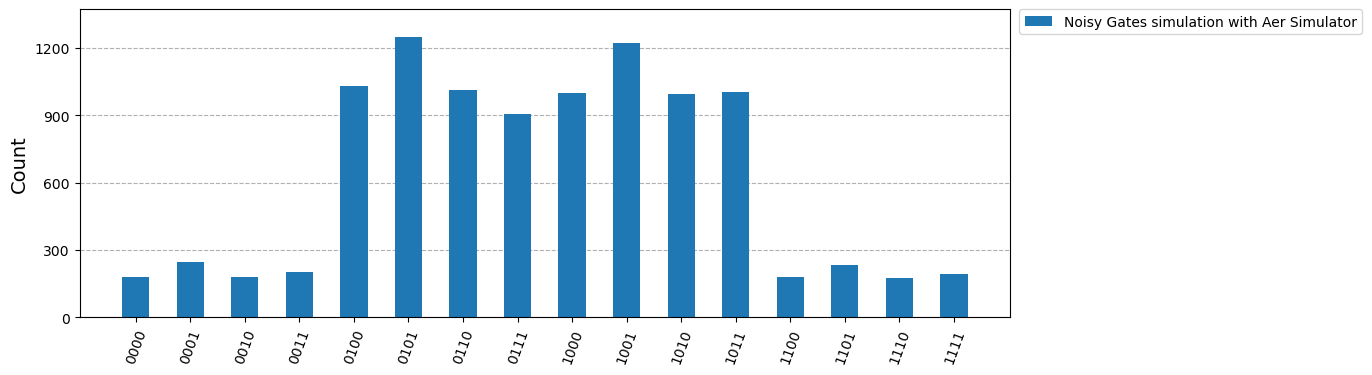

In [66]:
counts_noise_aer_uccsd = probs_noise_aer_uccsd.get_counts()
plot_histogram(counts_noise_aer_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [67]:
probs_free_aer_uccsd = sim_free_aer.run(t_circ_uccsd, shots=10000).result()

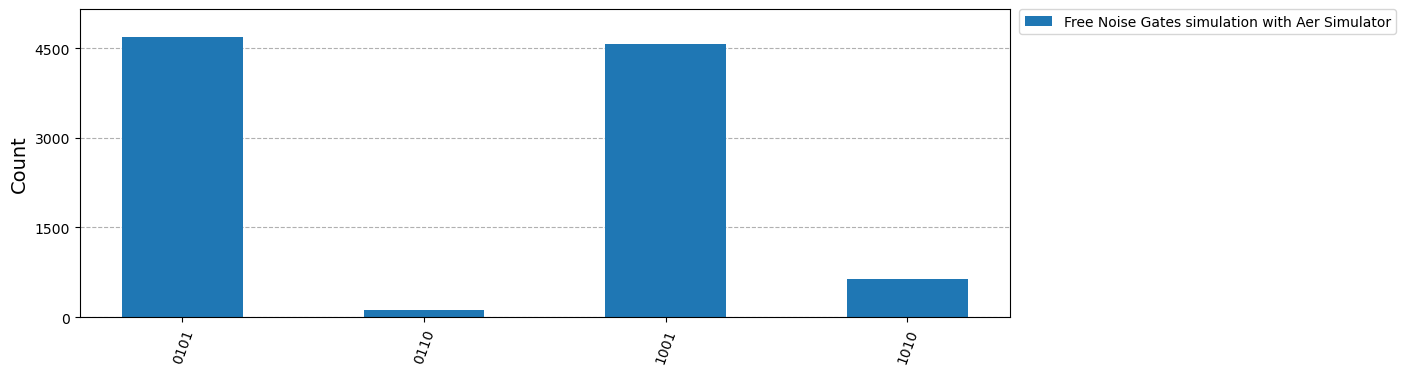

In [68]:
counts_free_aer_uccsd = probs_free_aer_uccsd.get_counts()
plot_histogram(counts_free_aer_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

##### 10. Constructing VQE and check results 

In [12]:
average_values_noisefree_uccsd, max_evaluations_noisefree_uccsd, vqe_solver_noisefree_uccsd, result_noisefree_uccsd, parameters_noisefree_uccsd, optimal_circuit_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=50)


/tmp/ipykernel_639/1771888045.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_uccsd, max_evaluations_noisefree_uccsd, vqe_solver_noisefree_uccsd, result_noisefree_uccsd, parameters_noisefree_uccsd, optimal_circuit_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=50)


##### 11. Solve and obtain minimum energy and correspondent state

Averaged groundstate energy (Hartree units): -0.9453794305877469
Averaged optimal parameters: {ParameterVectorElement(t[0]): np.float64(0.06816109099085355), ParameterVectorElement(t[1]): np.float64(0.13096438270959895), ParameterVectorElement(t[2]): np.float64(0.05557298508899172)}


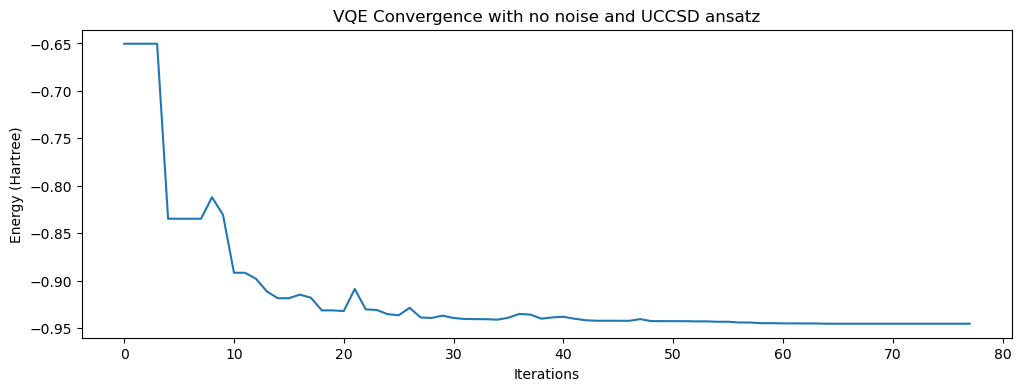

In [13]:
counts_noisefree_uccsd = np.arange(0, max_evaluations_noisefree_uccsd)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_uccsd, average_values_noisefree_uccsd, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and UCCSD ansatz")
pylab.savefig('vqe_noisfree_uccsd_avg_try')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_uccsd[-1])
print("Averaged optimal parameters:", parameters_noisefree_uccsd)

##### 12. Add measurements to the new circuit defining ground state

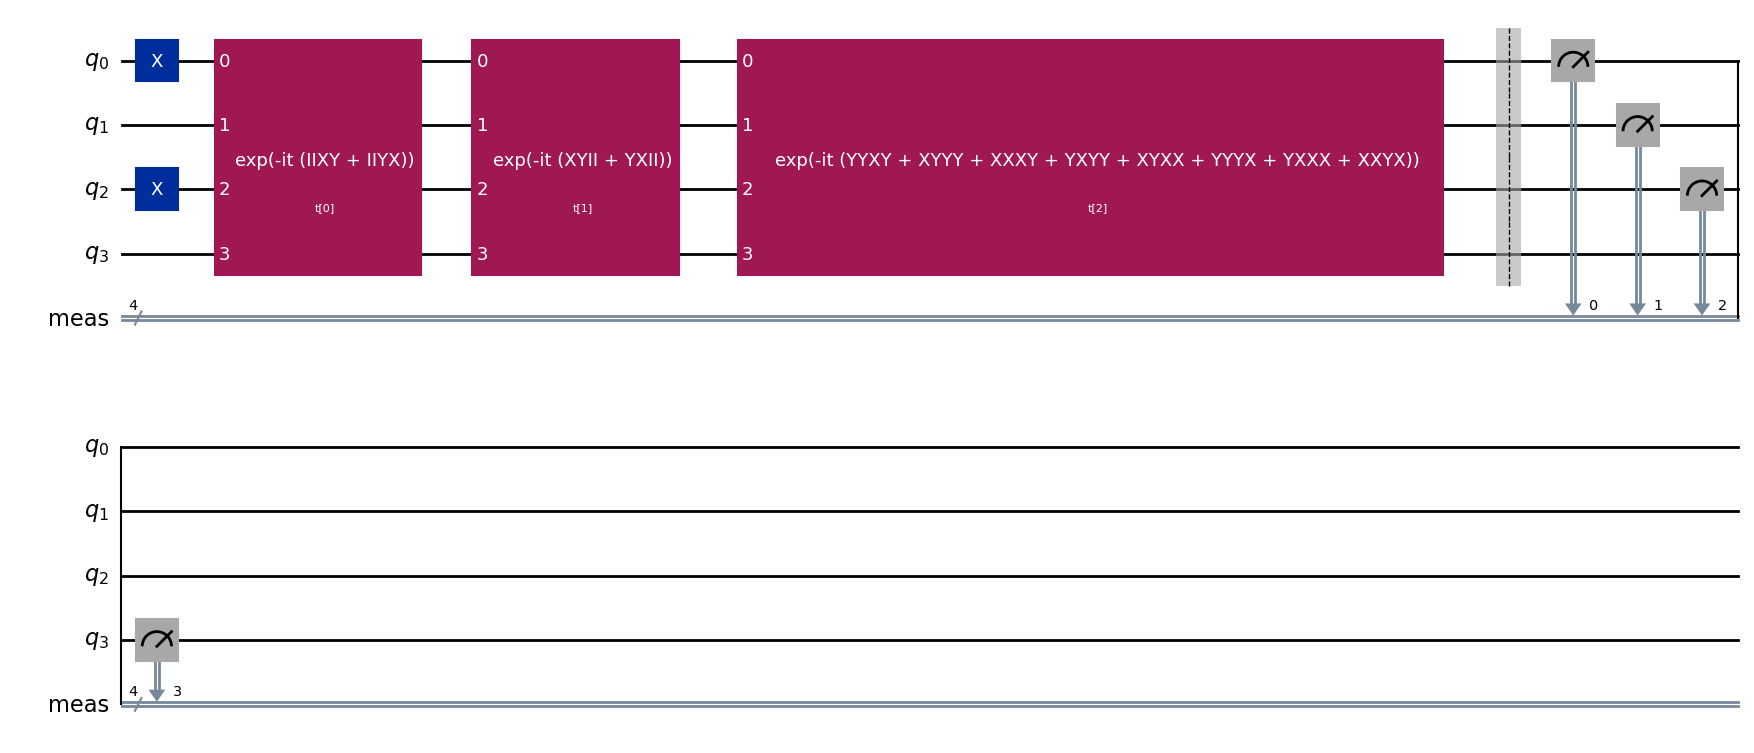

In [14]:
ansatz_circuit_min_noisefree_uccsd = optimal_circuit_noisefree_uccsd
ansatz_circuit_min_noisefree_uccsd = ansatz_circuit_min_noisefree_uccsd.decompose()  
ansatz_circuit_min_noisefree_uccsd.measure_all()
ansatz_circuit_min_noisefree_uccsd.draw('mpl')


##### 13. Define backend, transpile and assign new parameters as before

In [15]:
# transpilation of the circuit
t_circ_min_noisefree_uccsd = transpile(
    ansatz_circuit_min_noisefree_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)
t_circ_min_noisefree_uccsd = t_circ_min_noisefree_uccsd.assign_parameters(parameters_noisefree_uccsd)

##### 14. Define and run simulator with correspondent gate set

In [16]:
probs_noise_ander_min_noisefree_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 



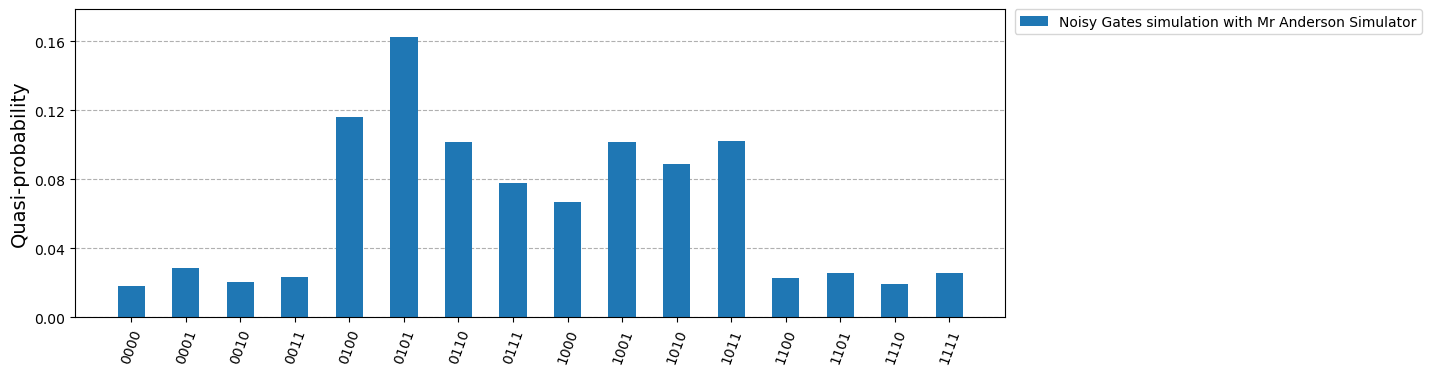

In [17]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noisefree_uccsd = fix_counts(probs_noise_ander_min_noisefree_uccsd, n_classic_bit)
plot_histogram(counts_noise_ander_min_noisefree_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [18]:
probs_free_ander_min_noisefree_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

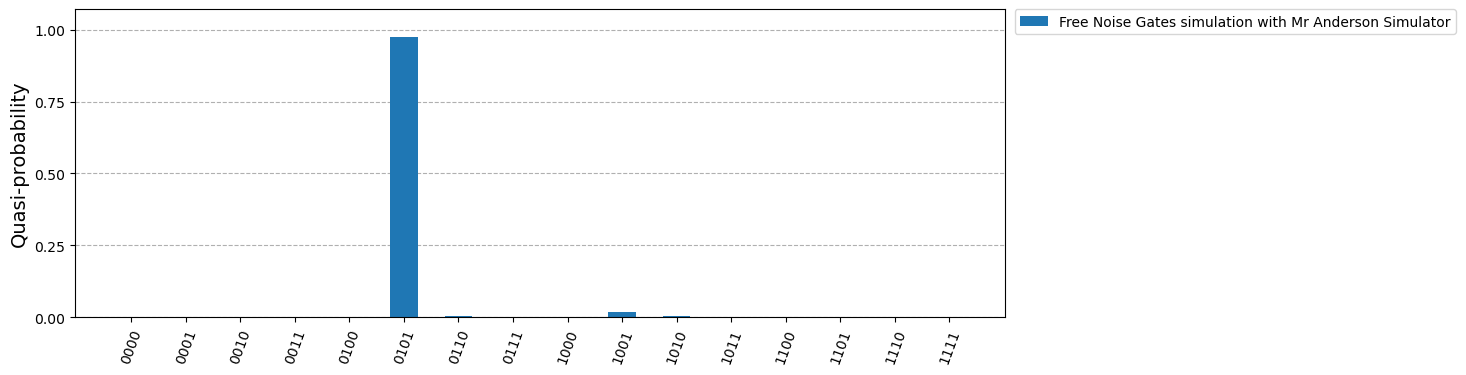

In [19]:
measured_qubit = n_classic_bit
counts_free_ander_min_noisefree_uccsd = fix_counts(probs_free_ander_min_noisefree_uccsd, n_classic_bit)
plot_histogram(counts_free_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [20]:
probs_noise_aer_min_noisefree_uccsd = sim_noise_aer.run(t_circ_min_noisefree_uccsd, shots=10000).result()

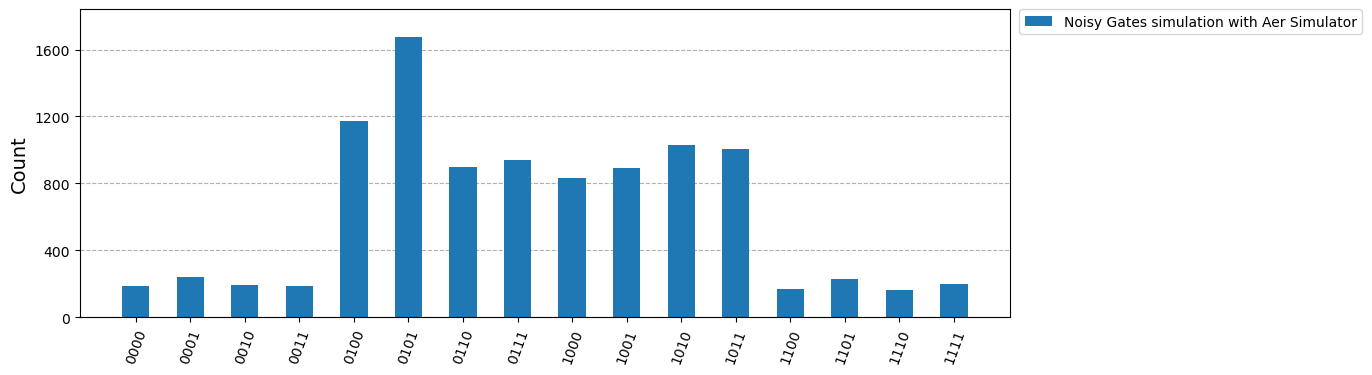

In [21]:
counts_noise_aer_min_noisefree_uccsd = probs_noise_aer_min_noisefree_uccsd.get_counts()
plot_histogram(counts_noise_aer_min_noisefree_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [22]:
probs_free_aer_min_noisefree_uccsd = sim_free_aer.run(t_circ_min_noisefree_uccsd, shots=10000).result()

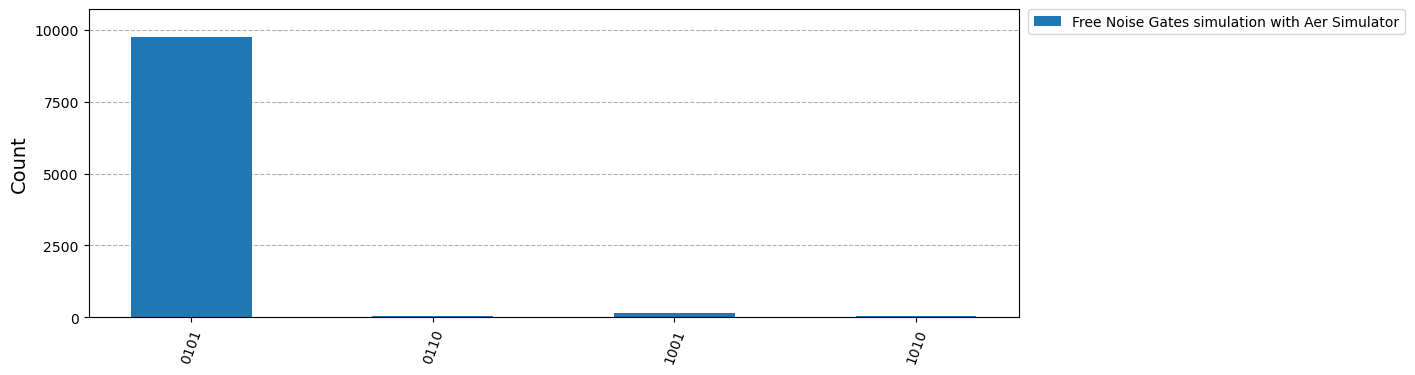

In [23]:
counts_free_aer_min_noisefree_uccsd = probs_free_aer_min_noisefree_uccsd.get_counts()
plot_histogram(counts_free_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [24]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [ ]:
average_values_noise_uccsd, max_evaluations_noise_uccsd, vqe_solver_noise_uccsd, result_noise_uccsd, parameters_noise_uccsd, optimal_circuit_noise_uccsd = run_vqe_with_averaging(ansatz_uccsd, noisy_estimator, mapper, es_problem, n_repeats=20)



Averaged groundstate energy (Hartree units): -0.4954044895144776
Averaged optimal parameters: {ParameterVectorElement(t[0]): np.float64(-1912.1941953538378), ParameterVectorElement(t[1]): np.float64(-2521.756627801882), ParameterVectorElement(t[2]): np.float64(1529.540570268633)}


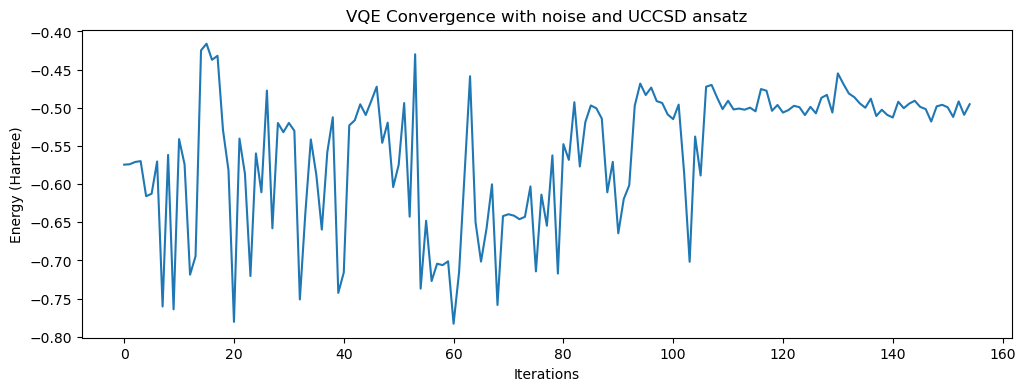

In [83]:
counts_noise_uccsd = np.arange(0, max_evaluations_noise_uccsd)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_uccsd, average_values_noise_uccsd, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and UCCSD ansatz")
pylab.savefig('vqe_noise_uccsd_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noise_uccsd[-1])
print("Averaged optimal parameters:", parameters_noise_uccsd)

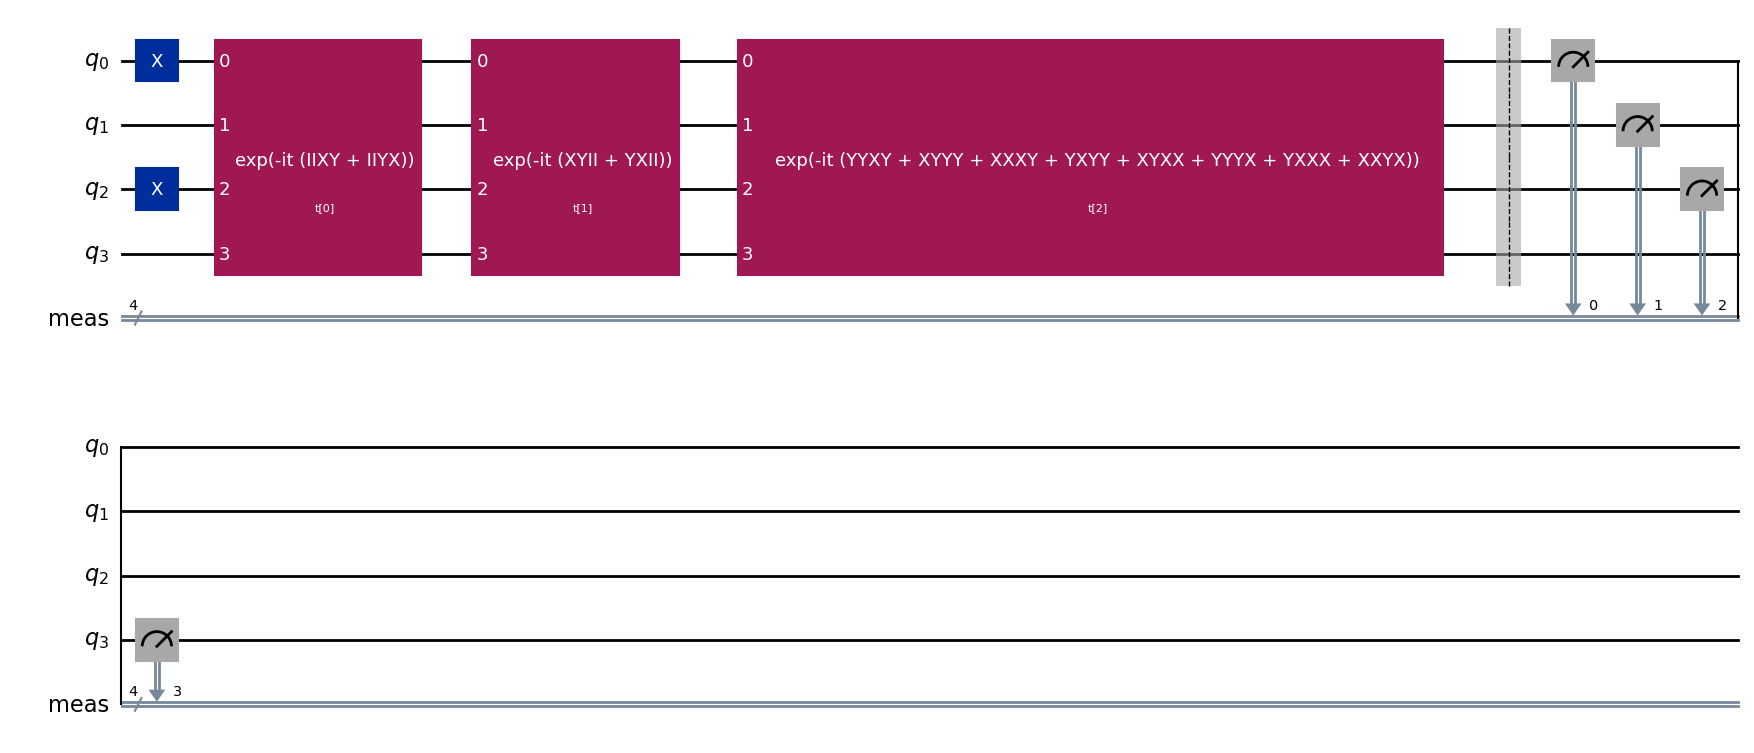

In [84]:
ansatz_circuit_min_noise_uccsd = optimal_circuit_noise_uccsd
ansatz_circuit_min_noise_uccsd = ansatz_circuit_min_noise_uccsd.decompose()  # Descompone las puertas en básicas
ansatz_circuit_min_noise_uccsd.measure_all()
ansatz_circuit_min_noise_uccsd.draw('mpl')

In [85]:
# transpilation of the circuit
t_circ_min_noise_uccsd = transpile(
    ansatz_circuit_min_noise_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)
t_circ_min_noise_uccsd = t_circ_min_noise_uccsd.assign_parameters(parameters_noise_uccsd)

In [86]:
probs_noise_ander_min_noise_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noise_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

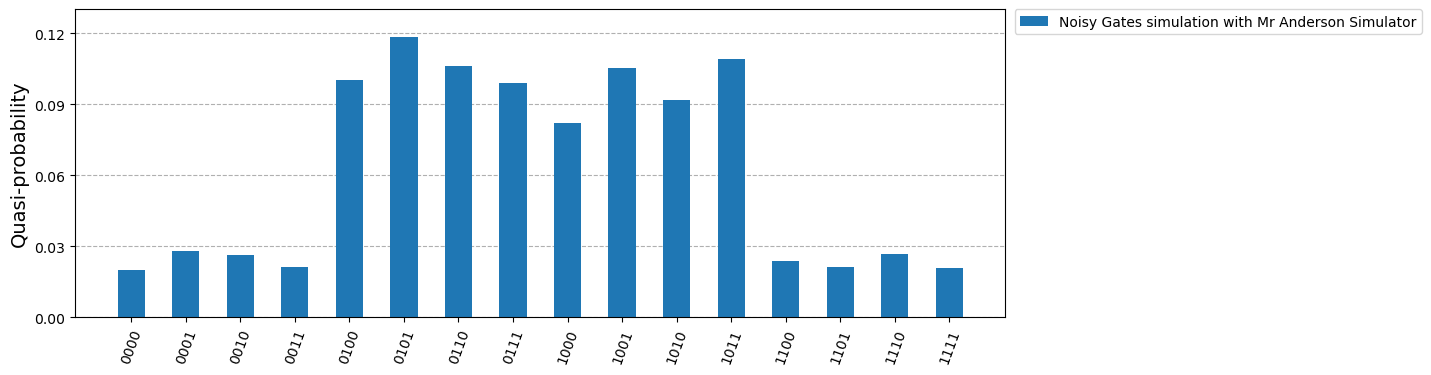

In [87]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noise_uccsd = fix_counts(probs_noise_ander_min_noise_uccsd, n_classic_bit)
plot_histogram(counts_noise_ander_min_noise_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [88]:
probs_free_ander_min_noise_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noise_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

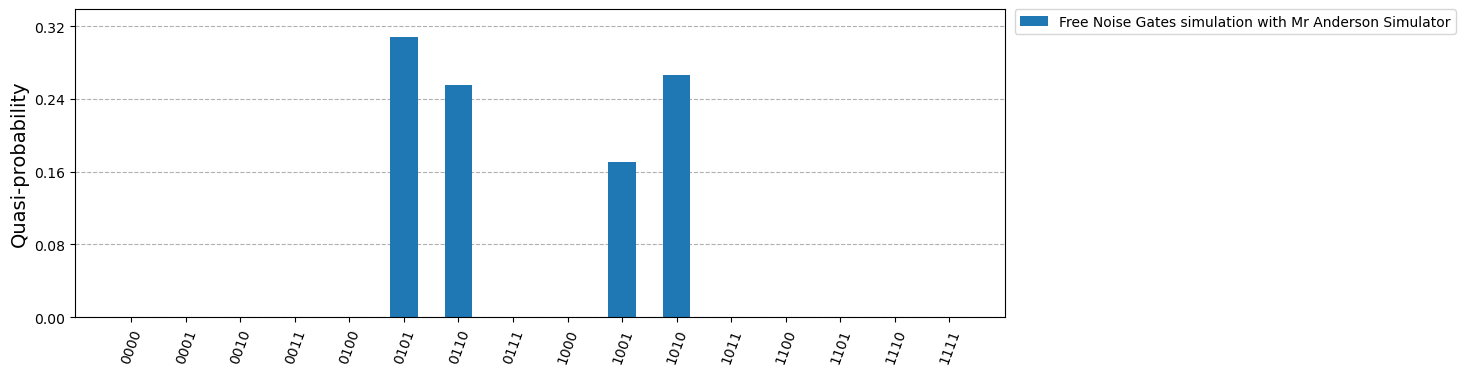

In [89]:
measured_qubit = n_classic_bit
counts_free_ander_min_noise_uccsd = fix_counts(probs_free_ander_min_noise_uccsd, n_classic_bit)
plot_histogram(counts_free_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [90]:
probs_noise_aer_min_noise_uccsd = sim_noise_aer.run(t_circ_min_noise_uccsd, shots=10000).result()

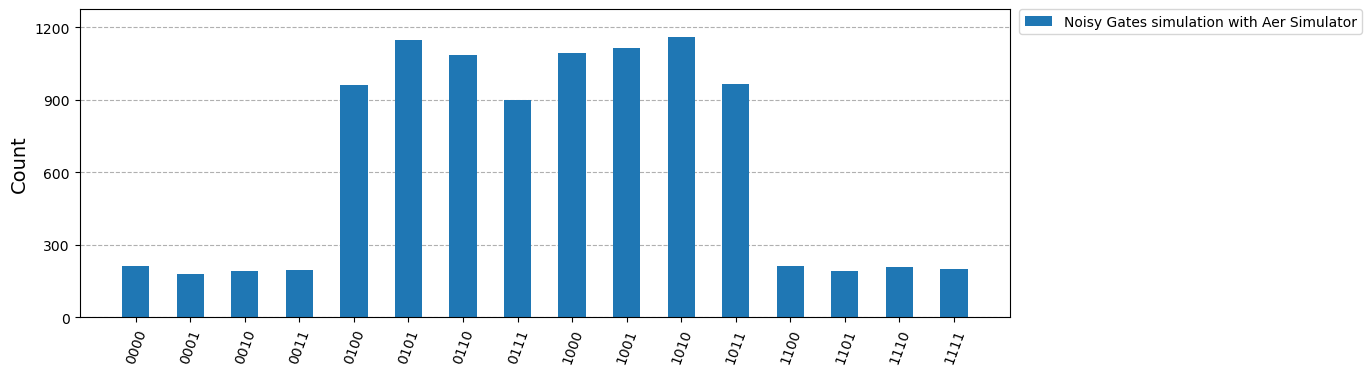

In [91]:
counts_noise_aer_min_noise_uccsd = probs_noise_aer_min_noise_uccsd.get_counts()
plot_histogram(counts_noise_aer_min_noise_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [92]:
probs_free_aer_min_noise_uccsd = sim_free_aer.run(t_circ_min_noise_uccsd, shots=10000).result()

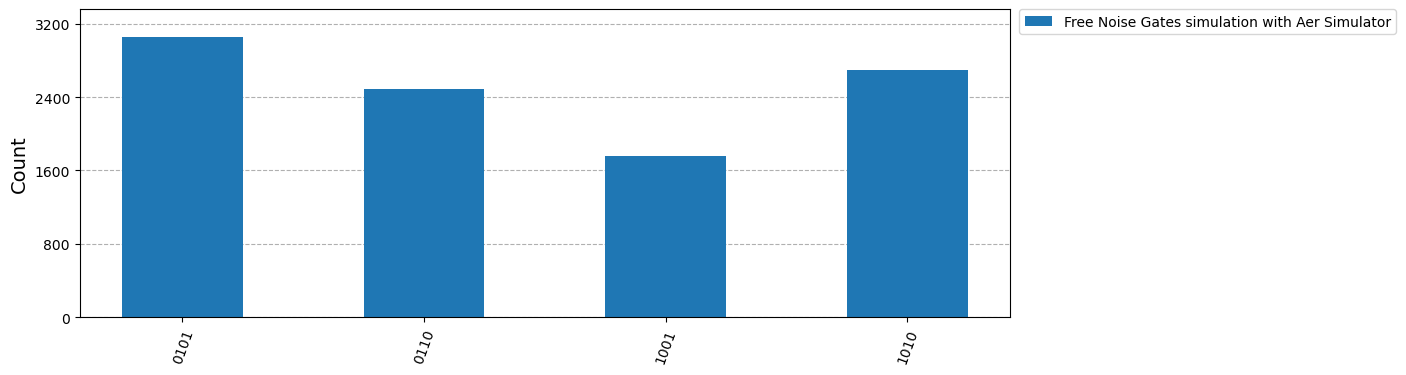

In [93]:
counts_free_aer_min_noise_uccsd = probs_free_aer_min_noise_uccsd.get_counts()
plot_histogram(counts_free_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

##### WE DO THE SAME WITH tUPS


In [137]:
import qiskit_aer
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeTorino
import pyscf
import numpy as np
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.qiskit_interface.interface import QuantumInterface
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler as Sampler
from qiskit.primitives import StatevectorSampler as SamplerV2

from qiskit_aer.primitives import Sampler as SamplerAer
from qiskit_aer.primitives import SamplerV2 as SamplerV2Aer

from qiskit_ibm_runtime import Sampler as SamplerIBM #outdated
from qiskit_ibm_runtime import SamplerV2 as SamplerV2IBM
from qiskit_aer import AerSimulator
aer = AerSimulator()

In [177]:
estimator = Estimator()
mapper = JordanWignerMapper()
QI = QuantumInterface(estimator,"tUPS", mapper, ansatz_options={"n_layers":10}) # we may need at least around 10 layers to get good results
ansatz_tups = QI.construct_circuit(num_orbs=es_problem.num_spatial_orbitals, num_elec=es_problem.num_particles)
ansatz_tups = QI.circuit
ansatz_tups.decompose()
ansatz_tups.measure_all()
#qc.draw('mpl')

Number of shots is None. Ideal simulator is assumed.


/tmp/ipykernel_138248/1304126541.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [178]:
t_circ_tups = transpile(
    ansatz_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=42,
    scheduling_method='asap'
)
print(t_circ_tups.parameters)
rng = np.random.default_rng(1111)
params_tups = rng.uniform(-np.pi, np.pi, size=t_circ_tups.num_parameters)
t_circ_tups = t_circ_tups.assign_parameters(params_tups)



ParameterView([Parameter(p000000000), Parameter(p000000001), Parameter(p000000002), Parameter(p000000003), Parameter(p000000004), Parameter(p000000005), Parameter(p000000006), Parameter(p000000007), Parameter(p000000008), Parameter(p000000009), Parameter(p000000010), Parameter(p000000011), Parameter(p000000012), Parameter(p000000013), Parameter(p000000014), Parameter(p000000015), Parameter(p000000016), Parameter(p000000017), Parameter(p000000018), Parameter(p000000019), Parameter(p000000020), Parameter(p000000021), Parameter(p000000022), Parameter(p000000023), Parameter(p000000024), Parameter(p000000025), Parameter(p000000026), Parameter(p000000027), Parameter(p000000028), Parameter(p000000029)])


In [140]:
probs_noise_ander_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit



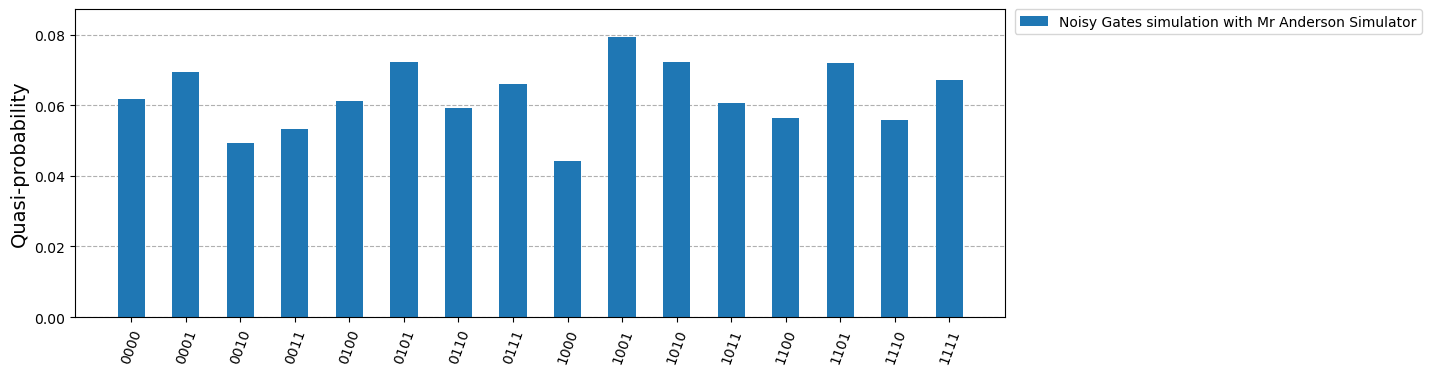

In [142]:
measured_qubit = n_classic_bit
counts_noise_ander_tups = fix_counts(probs_noise_ander_tups, n_classic_bit)
plot_histogram(counts_noise_ander_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [143]:
probs_free_ander_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit

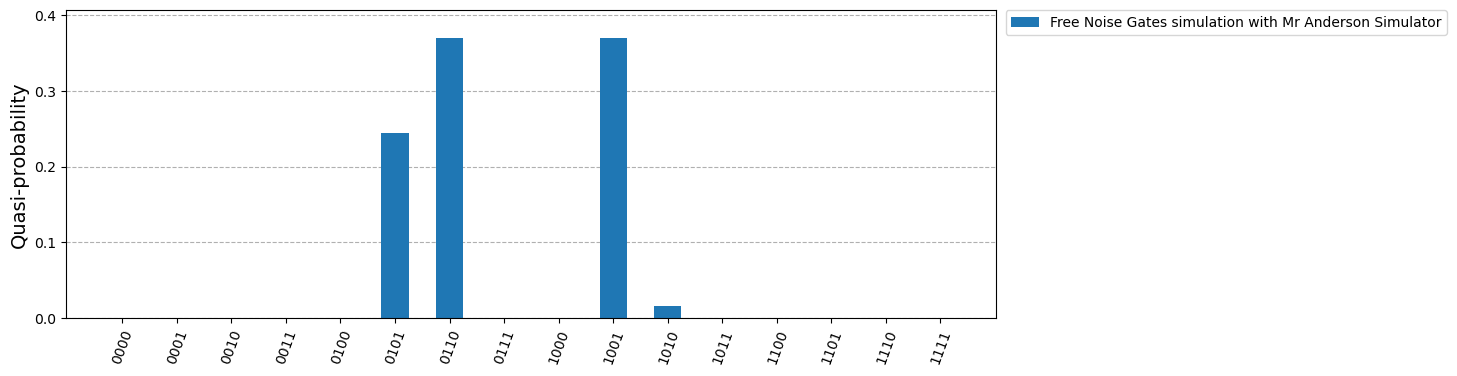

In [144]:
measured_qubit = n_classic_bit
counts_free_ander_tups = fix_counts(probs_free_ander_tups, n_classic_bit)
plot_histogram(counts_free_ander_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [145]:
probs_noise_aer_tups = sim_noise_aer.run(t_circ_tups, shots=10000).result()

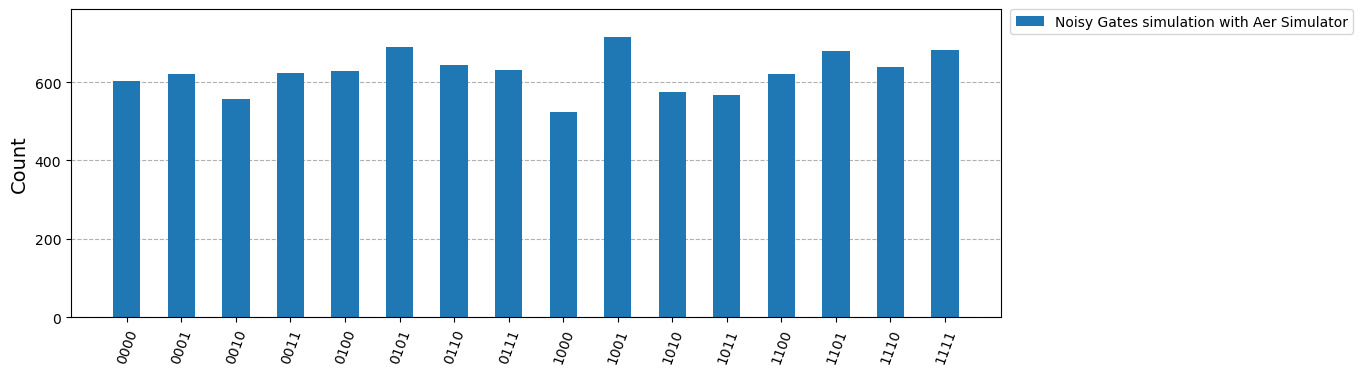

In [146]:
counts_noise_aer_tups = probs_noise_aer_tups.get_counts()
plot_histogram(counts_noise_aer_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [147]:
probs_free_aer_tups = sim_free_aer.run(t_circ_tups, shots=10000).result()

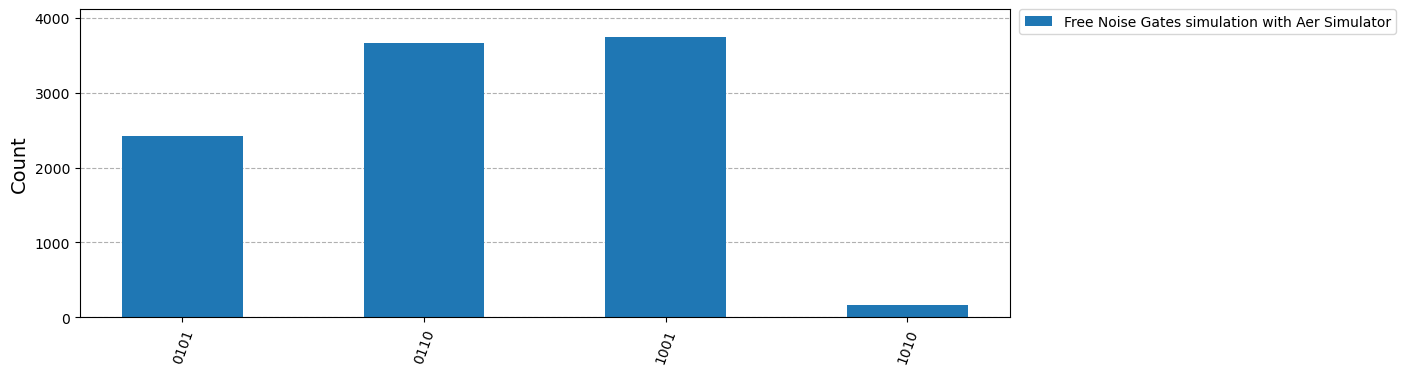

In [148]:
counts_free_aer_tups = probs_free_aer_tups.get_counts()
plot_histogram(counts_free_aer_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [204]:
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

average_values_noisefree_tups, max_evaluations_noisefree_tups, vqe_solver_noisefree_tups, result_noisefree_tups, parameters_noisefree_tups, optimal_circuit_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=5)


/tmp/ipykernel_138248/1877107836.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_tups, max_evaluations_noisefree_tups, vqe_solver_noisefree_tups, result_noisefree_tups, parameters_noisefree_tups, optimal_circuit_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=5)


Averaged groundstate energy (Hartree units): -0.9453795033916024
Averaged optimal parameters: {Parameter(p000000000): np.float64(0.47344407022040985), Parameter(p000000001): np.float64(0.6499553395725371), Parameter(p000000002): np.float64(0.3127721665404327), Parameter(p000000003): np.float64(0.4466296527190197), Parameter(p000000004): np.float64(0.24354609270021482), Parameter(p000000005): np.float64(0.6633356869389027), Parameter(p000000006): np.float64(0.7103870894220446), Parameter(p000000007): np.float64(0.36382207344699), Parameter(p000000008): np.float64(0.7945338242094542), Parameter(p000000009): np.float64(0.30859168179210034), Parameter(p000000010): np.float64(0.40796436297017424), Parameter(p000000011): np.float64(0.588300030185436), Parameter(p000000012): np.float64(0.48990851734591195), Parameter(p000000013): np.float64(0.5015930638779114), Parameter(p000000014): np.float64(0.5587614869579813), Parameter(p000000015): np.float64(0.4587443721635894), Parameter(p000000016): 

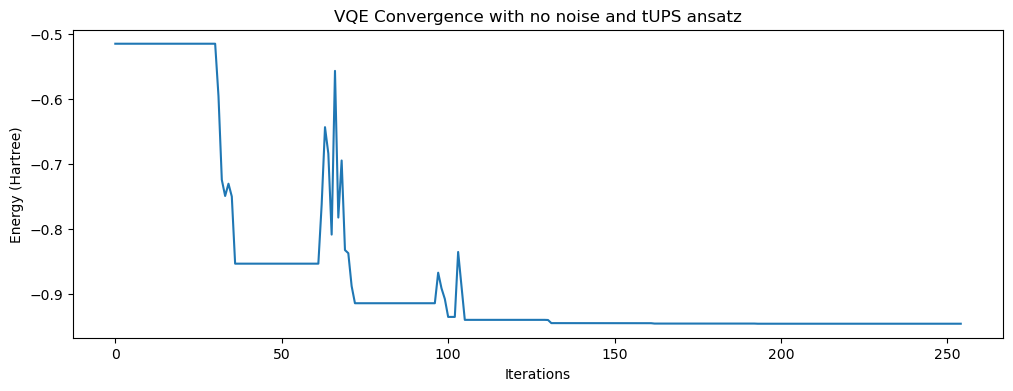

In [205]:
counts_noisefree_tups = np.arange(0, max_evaluations_noisefree_tups)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_tups, average_values_noisefree_tups, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and tUPS ansatz")
pylab.savefig('vqe_noisefree_tups_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_tups[-1])
print("Averaged optimal parameters:", parameters_noisefree_tups)

In [206]:
ansatz_circuit_min_noisefree_tups = optimal_circuit_noisefree_tups
ansatz_circuit_min_noisefree_tups = ansatz_circuit_min_noisefree_tups.decompose()  
ansatz_circuit_min_noisefree_tups.measure_all()
#ansatz_circuit_min_tups.draw('mpl')

In [207]:
#ansatz_circuit_min_noisefree_tups = ansatz_circuit_min_noisefree_tups.assign_parameters(parameters_noisefree_tups)

t_circ_min_noisefree_tups = transpile(
    ansatz_circuit_min_noisefree_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

t_circ_min_noisefree_tups = t_circ_min_noisefree_tups.assign_parameters(parameters_noisefree_tups)

In [153]:
probs_noise_ander_min_noisefree_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit)

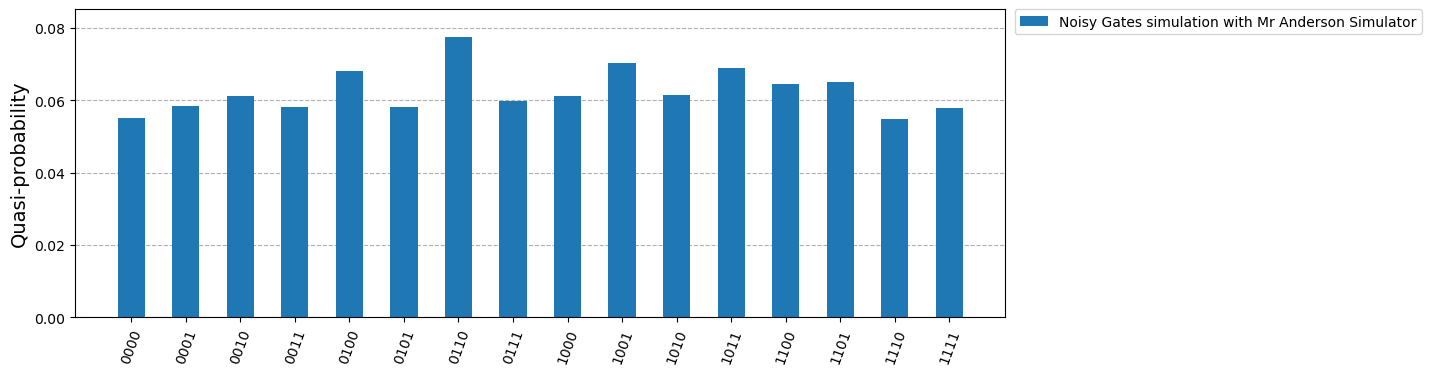

In [154]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noisefree_tups = fix_counts(probs_noise_ander_min_noisefree_tups, n_classic_bit)
plot_histogram(counts_noise_ander_min_noisefree_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [199]:
probs_free_ander_min_noisefree_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

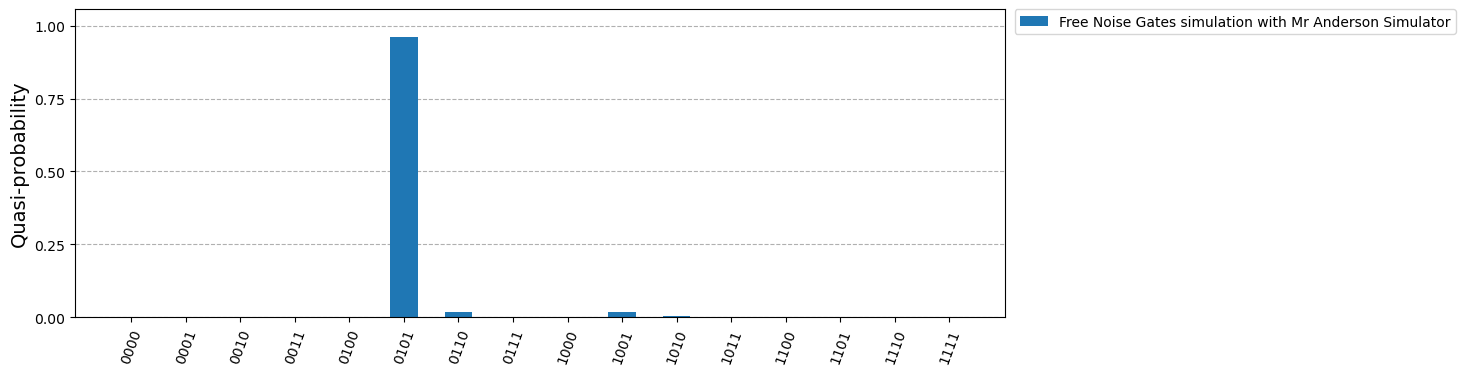

In [200]:
measured_qubit = n_classic_bit
counts_free_ander_min_noisefree_tups = fix_counts(probs_free_ander_min_noisefree_tups, n_classic_bit)
plot_histogram(counts_free_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [201]:
probs_noise_aer_min_noisefree_tups = sim_noise_aer.run(t_circ_min_noisefree_tups, shots=10000).result()

AerError: 'circuits have parameters but parameter_binds is not specified.'

In [158]:
counts_noise_aer_min_noisefree_tups = probs_noise_aer_min_noisefree_tups.get_counts()
plot_histogram(counts_noise_aer_min_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

NameError: name 'probs_noise_aer_min_noisefree_tups' is not defined

In [208]:
probs_free_aer_min_noisefree_tups = sim_free_aer.run(t_circ_min_noisefree_tups, shots=10000).result()

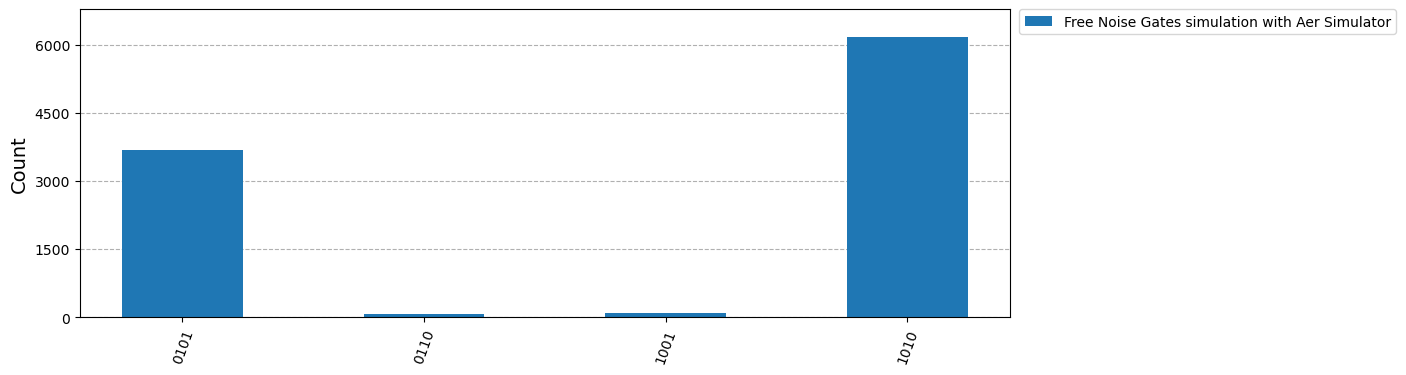

In [209]:
counts_free_aer_min_noisefree_tups = probs_free_aer_min_noisefree_tups.get_counts()
plot_histogram(counts_free_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [121]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [122]:
average_values_noise_tups, max_evaluations_noise_tups, vqe_solver_noise_tups, result_noise_tups, parameters_noise_tups, optimal_circuit_noise_tups = run_vqe_with_averaging(ansatz_tups, noisy_estimator, mapper, es_problem, n_repeats=1)


Averaged groundstate energy (Hartree units): -0.5521107208123777
Averaged optimal parameters: {Parameter(p000000000): np.float64(208128.24983240984), Parameter(p000000001): np.float64(-711815.5487987), Parameter(p000000002): np.float64(890983.4840305038), Parameter(p000000003): np.float64(180733.60494238485), Parameter(p000000004): np.float64(-756167.2372561712), Parameter(p000000005): np.float64(456612.4903853054)}


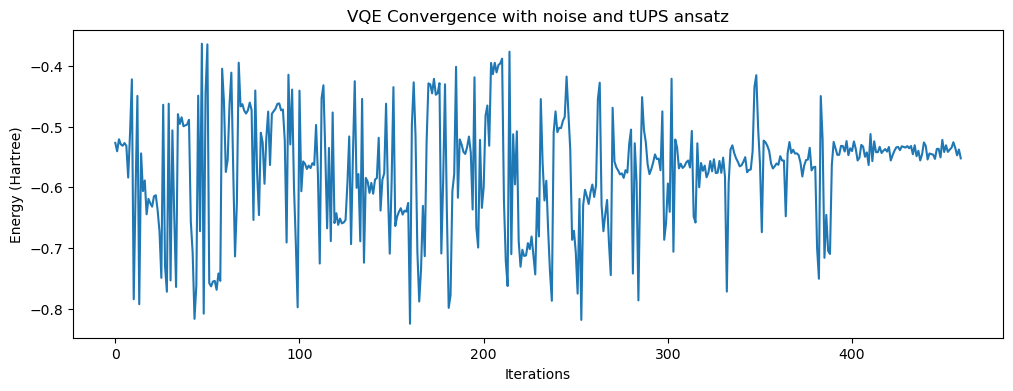

In [123]:
counts_noise_tups = np.arange(0, max_evaluations_noise_tups)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_tups, average_values_noise_tups, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and tUPS ansatz")
pylab.savefig('vqe_noise_tups_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noise_tups[-1])
print("Averaged optimal parameters:", parameters_noise_tups)

In [124]:
ansatz_circuit_min_noise_tups = optimal_circuit_noise_tups
ansatz_circuit_min_noise_tups_tups_tups = ansatz_circuit_min_noise_tups.decompose()  # Descompone las puertas en básicas
ansatz_circuit_min_noise_tups.measure_all()
#ansatz_circuit_min_noise.draw('mpl')

In [125]:
t_circ_min_noise_tups = transpile(
    ansatz_circuit_min_noise_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

t_circ_min_noise_tups = t_circ_min_noise_tups.assign_parameters(parameters_noise_tups)

In [126]:
probs_noise_ander_min_noise_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noise_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit)

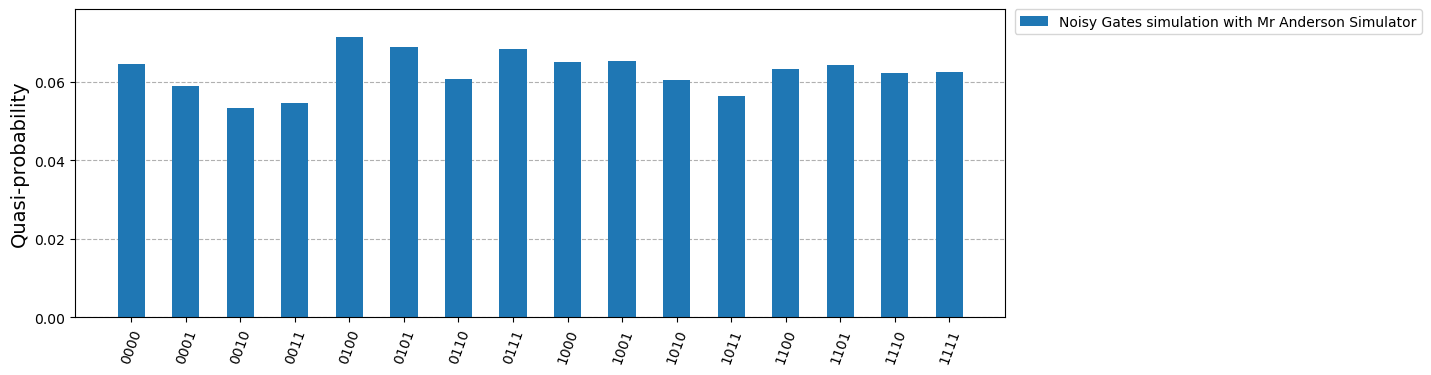

In [127]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noise_tups = fix_counts(probs_noise_ander_min_noise_tups, n_classic_bit)
plot_histogram(counts_noise_ander_min_noise_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [130]:
probs_free_ander_min_noise_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noise_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

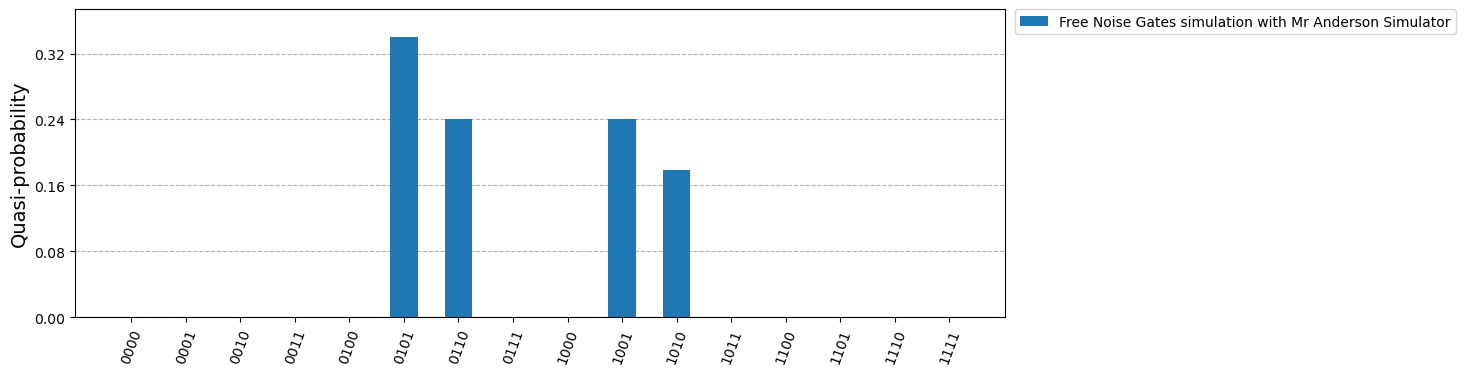

In [131]:
measured_qubit = n_classic_bit
counts_free_ander_min_noise_tups = fix_counts(probs_free_ander_min_noise_tups, n_classic_bit)
plot_histogram(counts_free_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [132]:
probs_noise_aer_min_noise_tups = sim_noise_aer.run(t_circ_min_noise_tups, shots=10000).result()

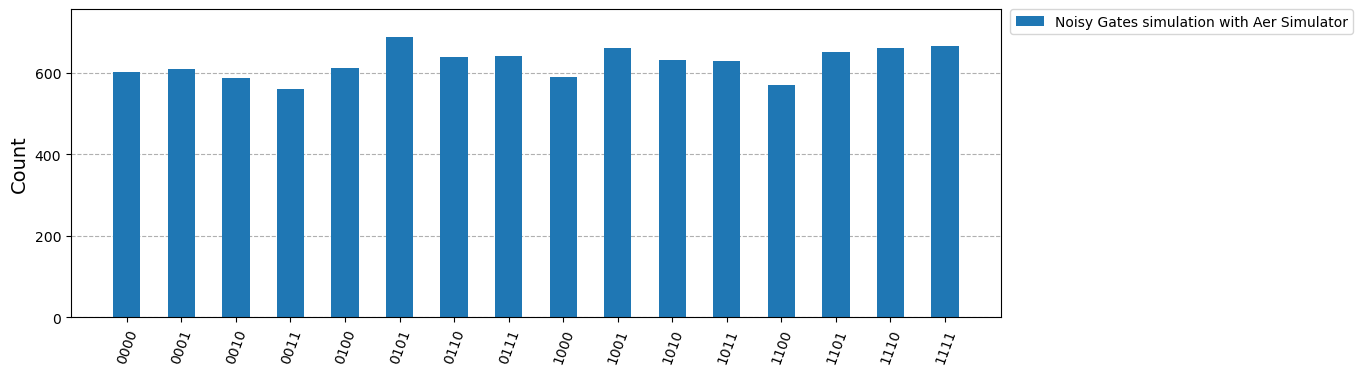

In [133]:
counts_noise_aer_min_noise_tups = probs_noise_aer_min_noise_tups.get_counts()
plot_histogram(counts_noise_aer_min_noise_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [134]:
probs_free_aer_min_noise_tups = sim_free_aer.run(t_circ_min_noise_tups, shots=10000).result()

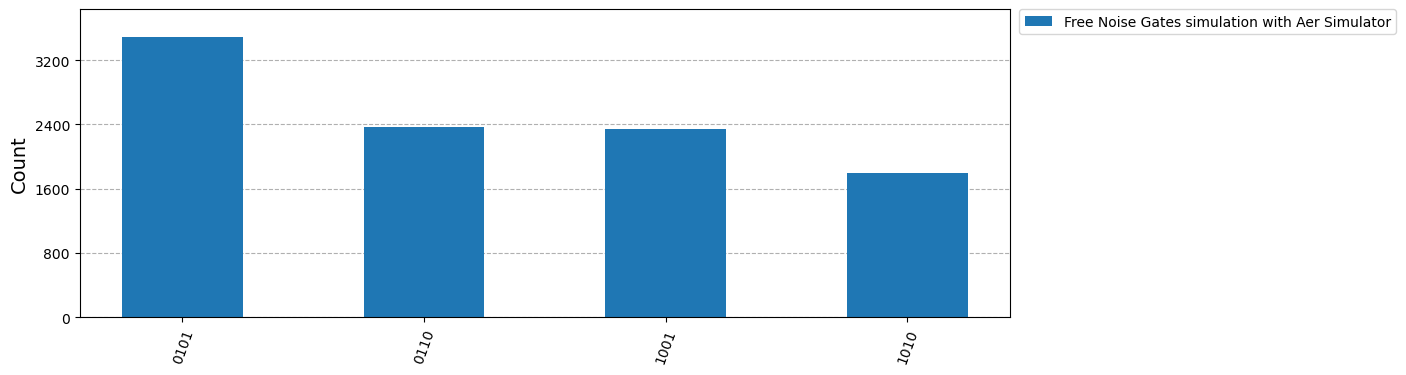

In [135]:
counts_free_aer_min_noise_tups = probs_free_aer_min_noise_tups.get_counts()
plot_histogram(counts_free_aer_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [7]:
backend = FakeKyiv()
#backend = provider.backend('ibm_kyiv')
print(backend.qubit_properties(0))
print(backend.qubit_properties(1))
print(backend.qubit_properties(2))
print(backend.qubit_properties(3))
config = backend.configuration()
print("Número de qubits:", config.n_qubits)

QubitProperties(t1=0.00036403810294451946, t2=0.00034854936444011657, frequency=4655609332.053975)
QubitProperties(t1=0.0005690055349559576, t2=0.00023207678408770585, frequency=4534975859.426203)
QubitProperties(t1=0.0003052640970754664, t2=0.0001197420446260147, frequency=4680110183.2333765)
QubitProperties(t1=0.00034493619450739663, t2=0.0001656597804188118, frequency=4606655659.877273)
Número de qubits: 127


In [3]:
properties = backend.properties()
for qubit, qubit_props in enumerate(properties.qubits):
    t1 = qubit_props[0].value  # T1
    t2 = qubit_props[1].value  # T2
    print(f"Qubit {qubit}: T1={t1:.2e} s, T2={t2:.2e} s")

Qubit 0: T1=3.64e+02 s, T2=3.49e+02 s
Qubit 1: T1=5.69e+02 s, T2=2.32e+02 s
Qubit 2: T1=3.05e+02 s, T2=1.20e+02 s
Qubit 3: T1=3.45e+02 s, T2=1.66e+02 s
Qubit 4: T1=4.37e+02 s, T2=1.11e+02 s
Qubit 5: T1=2.21e+02 s, T2=3.05e+02 s
Qubit 6: T1=3.89e+02 s, T2=1.92e+02 s
Qubit 7: T1=4.21e+02 s, T2=3.71e+02 s
Qubit 8: T1=3.64e+02 s, T2=2.53e+02 s
Qubit 9: T1=4.82e+02 s, T2=5.08e+01 s
Qubit 10: T1=2.72e+02 s, T2=4.91e+01 s
Qubit 11: T1=3.81e+02 s, T2=3.25e+02 s
Qubit 12: T1=4.50e+02 s, T2=3.06e+02 s
Qubit 13: T1=3.55e+02 s, T2=7.77e+01 s
Qubit 14: T1=2.94e+02 s, T2=1.97e+02 s
Qubit 15: T1=4.30e+02 s, T2=7.53e+01 s
Qubit 16: T1=1.19e+02 s, T2=9.04e+01 s
Qubit 17: T1=1.97e+02 s, T2=4.80e+01 s
Qubit 18: T1=3.74e+02 s, T2=5.32e+01 s
Qubit 19: T1=2.18e+02 s, T2=2.07e+02 s
Qubit 20: T1=4.83e+02 s, T2=4.37e+02 s
Qubit 21: T1=4.03e+02 s, T2=7.77e+01 s
Qubit 22: T1=3.90e+02 s, T2=1.47e+02 s
Qubit 23: T1=2.56e+02 s, T2=1.38e+02 s
Qubit 24: T1=3.19e+02 s, T2=8.99e+01 s
Qubit 25: T1=2.27e+02 s, T2=2.62e+0